### Imports and set up

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#torch imports 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from torcheeg.io.eeg_signal import EEGSignalIO
from torcheeg.models import DGCNN
from sklearn.model_selection import train_test_split
from torcheeg import transforms
from torcheeg.models.gnn.dgcnn import GraphConvolution
# helper sctipts 
from training import TrainNN
from cka import CKACalculator

## Path constants
path="artifacts"
modelname="dgcnn_mod"
data_path = "../data/"
preprocessed_data_path = f"{path}/preprocessed_data.npy"

## Establish connection to datafile
IO = EEGSignalIO(io_path=str(data_path), io_mode='lmdb')

## Read metadata dataframeimports
metadata = pd.read_csv(data_path + 'sample_metadata.tsv', sep='\t')

### Load data

In [13]:
# Verifying connection to data
idxs = np.arange(len(metadata))

# Read features and labels as torch tensors
X = torch.FloatTensor(np.array([IO.read_eeg(str(i)) for i in idxs]))
y = torch.tensor(metadata["value"].values, dtype=torch.long)

In [14]:
bands = {"delta": [1, 4],"theta": [4, 8],"alpha": [8, 14],"beta": [14, 31],"gamma": [31, 49]}
if os.path.exists(preprocessed_data_path):
    
    with open(preprocessed_data_path, "rb") as f:
        X_bde = np.load(f)
    
else:
    t = transforms.BandDifferentialEntropy(band_dict=bands)

    X_bde = []
    for i in range(X.shape[0]):

        bde_tmp = t(eeg=X[i])
        X_bde.append(bde_tmp)

    X_bde = [x["eeg"] for x in X_bde]

    with open(preprocessed_data_path, "wb") as f:
        np.save(f, X_bde)

X_bde = torch.FloatTensor(X_bde)      

### Split data into train, validation and test sets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_bde, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

assert X_train.shape[1]==X.shape[1],"Preprossed data lost channels"
assert X_train.shape[2]==len(bands),"Preprossed data does have incorrect amount of bands"
assert (X_train.shape[0]+X_val.shape[0]+X_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
assert (y_train.shape[0]+y_val.shape[0]+y_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"

In [16]:
# get dimensions

nsamples_train, nchannels_train, bands = X_train.shape
nsamples_val, nchannels_val, bands = X_val.shape

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

### Training & model hyperparameters

In [17]:
# Model parameters
num_chans = 5
num_electrodes = 22
num_outputs = y.max().item() + 1
num_layers = 2
hid_chans = 32

# Training parameters
lr = 1e-4
epochs = 40
w_decay = 0

#Models 
modruns = 3
plot=True
new_models=False

In [18]:
def plot_matrix(title,matrix_data,xlabel,ylabel):
    """
    Used for plotting our matrixis to unsure they are all the same format.

    ...
    Parameters
    ------------
    title : string
        The title on the plot
    matrix_data : np.ndarray
        The data for creating the heatmap
    xlabel : list
        A list of strings for the label marks
    ylabel : list
        A list of strings for the label marks
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(matrix_data,cmap='inferno',vmin=0,vmax=1)
    plt.xticks(ticks=np.arange(len(xlabel)), labels=xlabel)
    plt.yticks(ticks=np.arange(len(ylabel)), labels=ylabel)
    # Colourbar, with fixed ticks to enable comparison
    cbar = plt.colorbar()
    cbar.set_ticks([x/20 for x in range(0,21)])

    for i in range(matrix_data.shape[0]):  
        for j in range(matrix_data.shape[1]):
            plt.text(j, i, f"{matrix_data[i, j]:.2f}", ha='center', va='center', color='white' if matrix_data[i, j] < 0.5 else 'black')

    plt.title(title)
    ax = plt.gca()  
    ax.set_xticks(np.arange(len(xlabel)) - 0.5, minor=True)
    ax.set_yticks(np.arange(len(ylabel)) - 0.5, minor=True)
    ax.grid(which="minor", color="Black", linewidth=0.5)
    ax.tick_params(which="minor", size=0) 

    plt.show()

## Train model

### Train 4 models and calculate CKA matrices for pairs of models

In [19]:
mods = []

def train_models(model,modeltrainer,num_models=1,new =False, prints=False):
    """
    Training a model with random initialisation but consitent parameters. 
    
    Hyper parameters should be set outside of this function 
    
    path and model_names are both needed parameters that need to be defined outside of this function. 
    
    Path is to where your artifacts are located and model_name is what the model is called 
    
    ...
    
    Parameters
    -----------
    model : nn.modules
        The model being trained
    modeltrainer : training class
        a class for training the model provided should return a trained model
    num_models : int 
        Default 1, how many models it trains
    new : bool
        Weather it should attempt to use saved models
    """
    for i in range(num_models):
        
        tmp_mod = model(in_channels=num_chans, num_electrodes=num_electrodes, 
                              hid_channels=hid_chans, num_layers=num_layers, num_classes=num_outputs)
        model_path=f"{path}/{modelname}{i}.pth"
        print(f"Model {i}:")
        if new or not os.path.exists(model_path):    
            if not os.path.exists(model_path) and not new:
                print(f"Could not resolve path: {model_path}")
            trainer = modeltrainer()
            mods.append(trainer.train_model(tmp_mod, train_loader, val_loader, learning_rate=lr,path=path,name=modelname,
                                            w_decay=w_decay,epochs=epochs, prints=prints, modrun=i))
        else: 
            tmp_mod.load_state_dict(torch.load(model_path))
            tmp_mod.eval()
            mods.append([tmp_mod,[]])
            

# Training 4 models 
train_models(DGCNN,TrainNN,num_models=modruns,prints=plot, new=new_models)

Model 0:
Model 1:
Model 2:


Processing CKA: 100%|██████████| 49/49 [00:00<00:00, 398.89it/s]


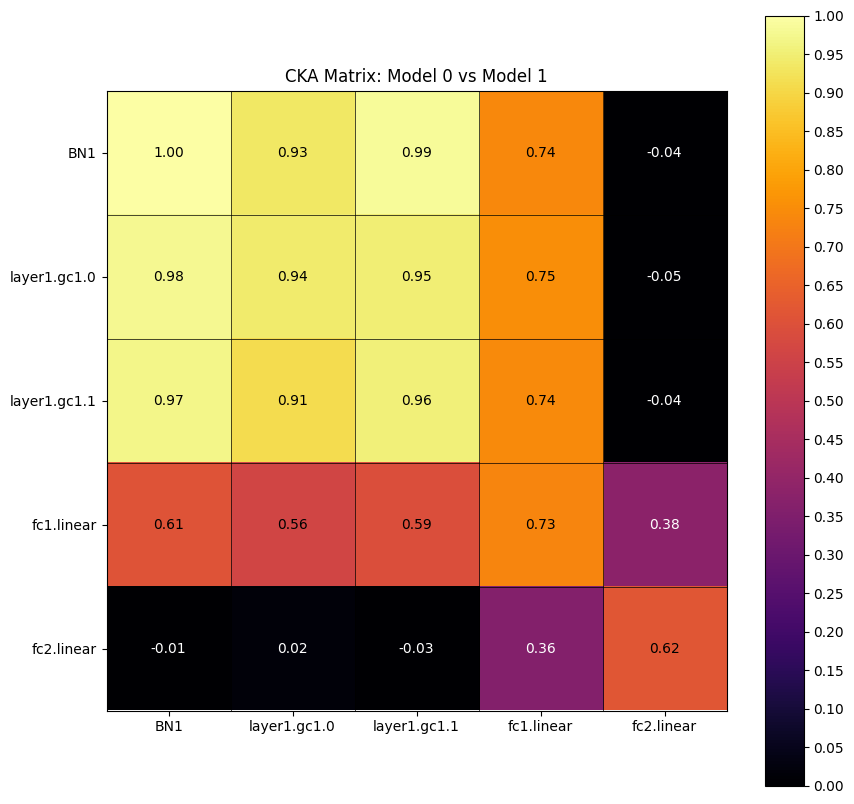

Processing CKA: 100%|██████████| 49/49 [00:00<00:00, 642.50it/s]


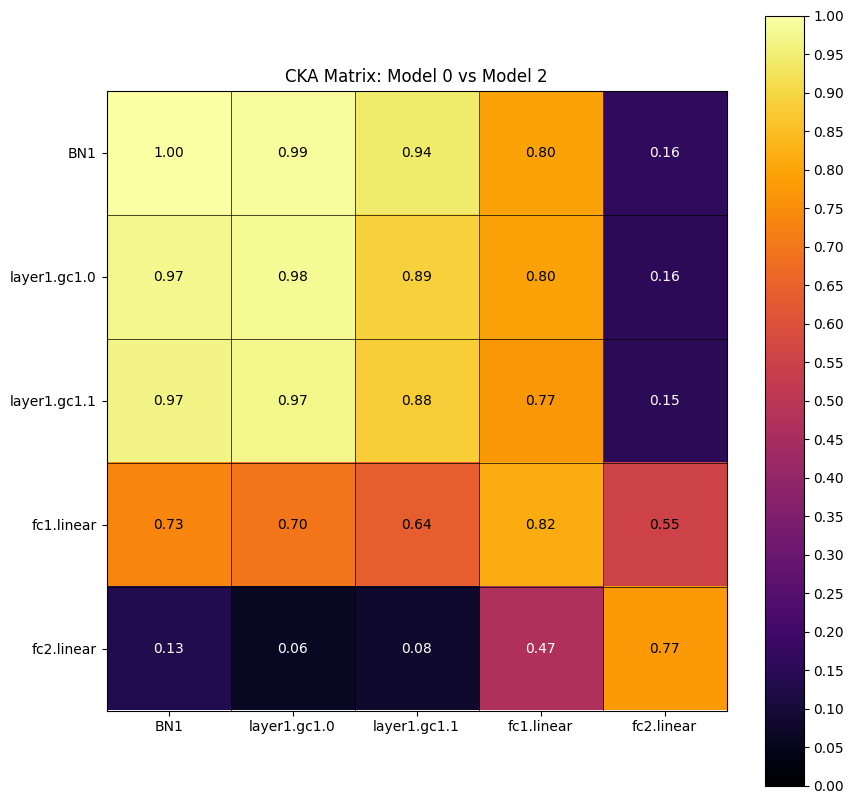

Processing CKA: 100%|██████████| 49/49 [00:00<00:00, 363.41it/s]


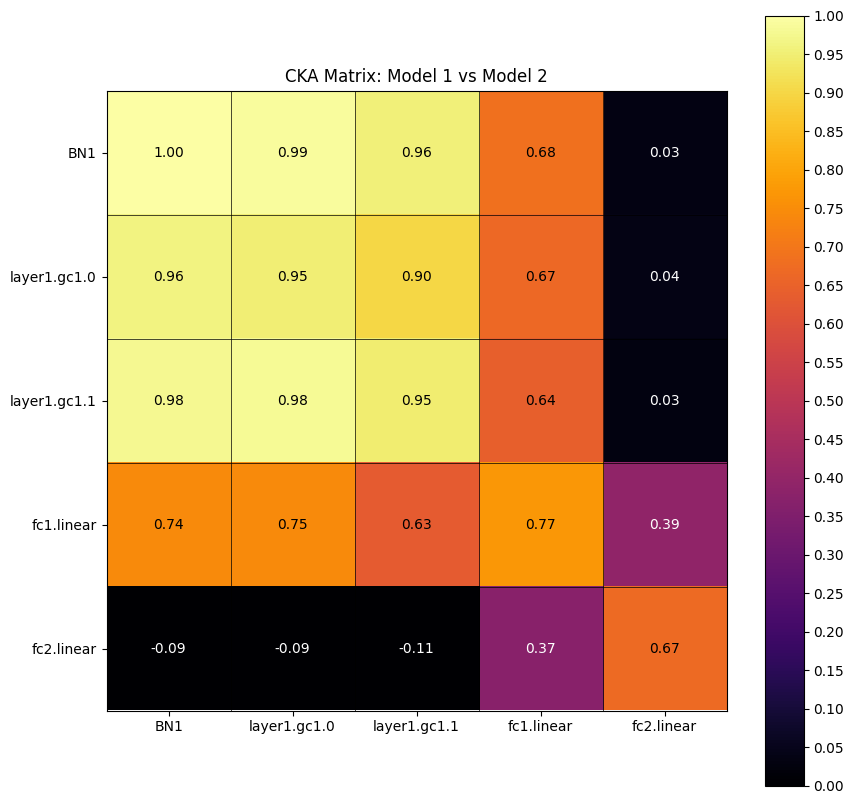

In [ ]:
cka_all = []  
for i in range(modruns):
    for j in range(i+1,modruns):
        calculator = CKACalculator(model1=mods[i][0], model2=mods[j][0], dataloader=train_loader,
                                layers_to_hook=(nn.Conv2d, nn.Linear, nn.AdaptiveAvgPool2d, GraphConvolution, nn.BatchNorm1d))
        cka_output = calculator.calculate_cka_matrix()
        cka_all.append(cka_output)
        if plot:
            #Plot the matrix
            plot_matrix(f'CKA Matrix: Model {i} vs Model {j}',cka_output.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)


In [60]:
num_test=100
error = np.zeros(num_test)
for e in range(num_test):
    print(e)
    calculator = CKACalculator(model1=mods[0][0], model2=mods[1][0], dataloader=train_loader,
                                    layers_to_hook=(nn.Conv2d, nn.Linear, nn.AdaptiveAvgPool2d, GraphConvolution, nn.BatchNorm1d))
    cka_output = calculator.calculate_cka_matrix()
    error[e]=cka_output[0][4]

                

0


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 18.97it/s]


1


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 27.70it/s]


2


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 28.32it/s]


3


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 24.73it/s]


4


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 24.06it/s]


5


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 27.53it/s]


6


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 27.24it/s]


7


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 22.46it/s]


8


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 26.84it/s]


9


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 18.63it/s]


10


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 22.00it/s]


11


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 29.20it/s]


12


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 21.19it/s]


13


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 25.07it/s]


14


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 21.76it/s]


15


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 25.00it/s]


16


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 20.95it/s]


17


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 26.65it/s]


18


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 27.27it/s]


19


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 23.80it/s]


20


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 19.29it/s]


21


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 36.66it/s]


22


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 33.99it/s]


23


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 37.78it/s]


24


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 33.19it/s]


25


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 25.39it/s]


26


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 29.91it/s]


27


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 23.94it/s]


28


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 31.16it/s]


29


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 21.61it/s]


30


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 37.78it/s]


31


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 32.71it/s]


32


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 20.83it/s]


33


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 21.62it/s]


34


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 16.73it/s]


35


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 25.83it/s]


36


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 28.77it/s]


37


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 31.66it/s]


38


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 22.52it/s]


39


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 23.65it/s]


40


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 26.71it/s]


41


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 28.31it/s]


42


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 24.93it/s]


43


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 30.75it/s]


44


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 26.55it/s]


45


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 30.93it/s]


46


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 28.21it/s]


47


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 30.45it/s]


48


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 28.24it/s]


49


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 27.40it/s]


50


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 26.02it/s]


51


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 17.34it/s]


52


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 22.42it/s]


53


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 16.62it/s]


54


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 21.40it/s]


55


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 28.70it/s]


56


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 27.66it/s]


57


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 22.43it/s]


58


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 17.16it/s]


59


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 28.47it/s]


60


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 22.07it/s]


61


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 18.39it/s]


62


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 17.20it/s]


63


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 24.22it/s]


64


Processing CKA: 100%|██████████| 49/49 [00:03<00:00, 16.10it/s]


65


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 24.73it/s]


66


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 27.68it/s]


67


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 23.57it/s]


68


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 20.55it/s]


69


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 29.55it/s]


70


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 17.78it/s]


71


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 18.82it/s]


72


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 22.64it/s]


73


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 24.73it/s]


74


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 17.22it/s]


75


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 21.30it/s]


76


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 19.65it/s]


77


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 21.01it/s]


78


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 20.83it/s]


79


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 25.39it/s]


80


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 24.30it/s]


81


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 19.85it/s]


82


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 24.35it/s]


83


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 23.44it/s]


84


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 17.26it/s]


85


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 17.18it/s]


86


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 17.93it/s]


87


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 20.85it/s]


88


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 25.09it/s]


89


Processing CKA: 100%|██████████| 49/49 [00:03<00:00, 14.69it/s]


90


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 18.73it/s]


91


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 25.22it/s]


92


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 19.75it/s]


93


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 16.38it/s]


94


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 16.90it/s]


95


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 20.82it/s]


96


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 18.55it/s]


97


Processing CKA: 100%|██████████| 49/49 [00:02<00:00, 21.80it/s]


98


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 25.57it/s]


99


Processing CKA: 100%|██████████| 49/49 [00:01<00:00, 24.67it/s]


In [62]:
print(f"Standard deviation: {np.std(error):.2f}")
print(f"Array max: {max(error)}\nArray min: {min(error)}\nArray mean: {np.mean(error)}")

Standard deviation: 0.11
Array max: 0.41422224044799805
Array min: -0.14155323803424835
Array mean: 0.04750505062664161


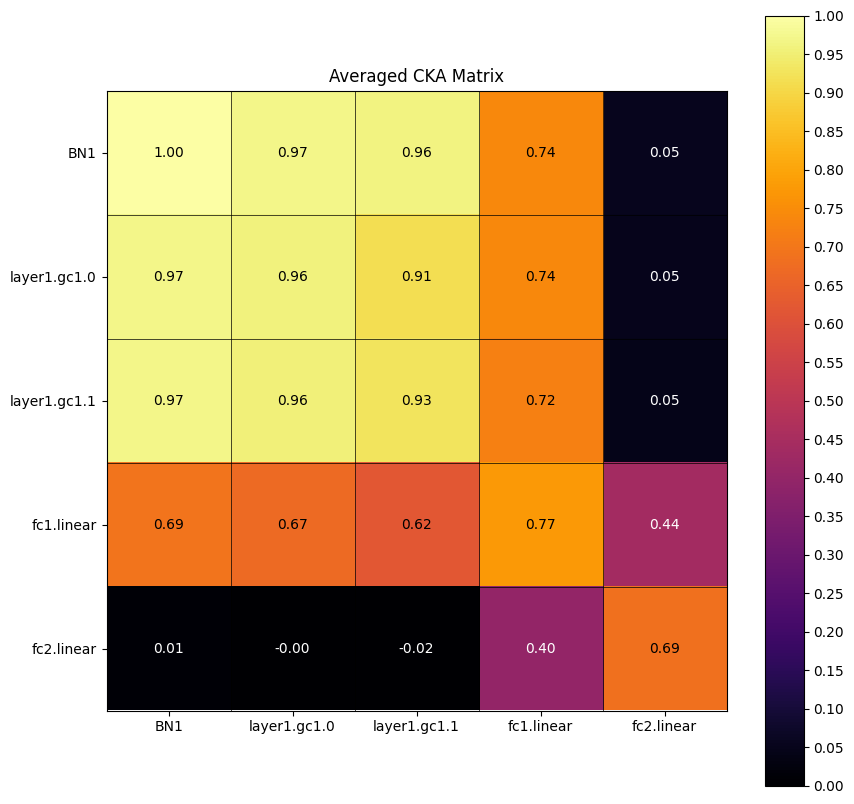

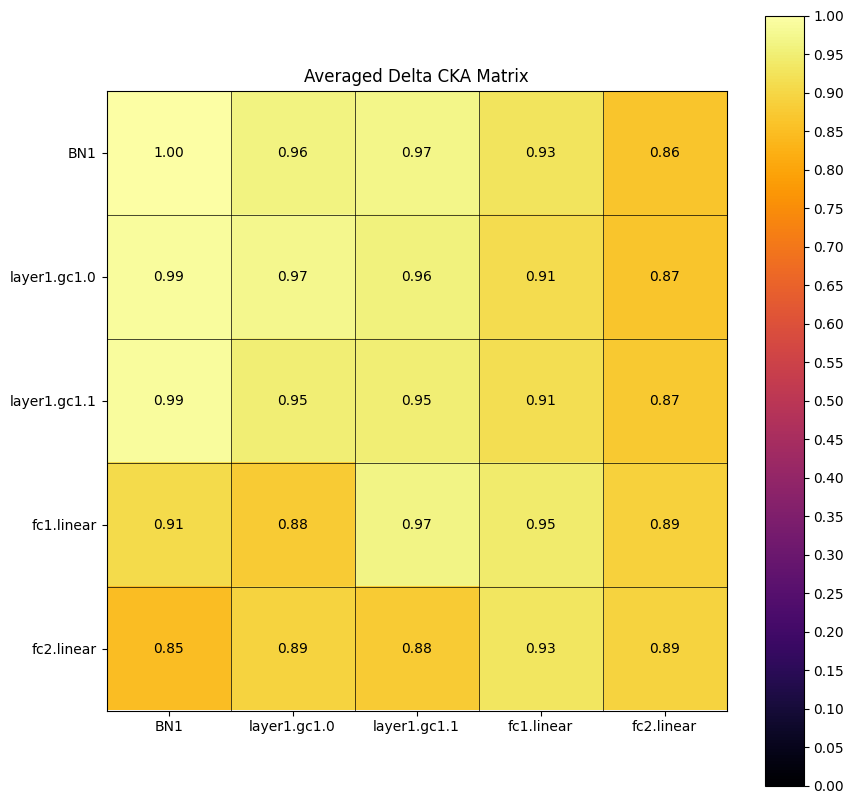

In [53]:
cka_stack = torch.stack(cka_all) 
average_cka_matrix = cka_stack.mean(dim=0)
delta_matrices = []

for i in range(len(cka_stack)):
    for j in range(i+1,len(cka_stack)):
        delta_matrices.append(torch.abs(cka_stack[i] - cka_stack[j])) 
        
delta_matrices = torch.stack(delta_matrices)  
average_delta_cka_matrix = 1- delta_matrices.mean(dim=0)  

plot_matrix("Averaged CKA Matrix",average_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)

plot_matrix("Averaged Delta CKA Matrix",average_delta_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)

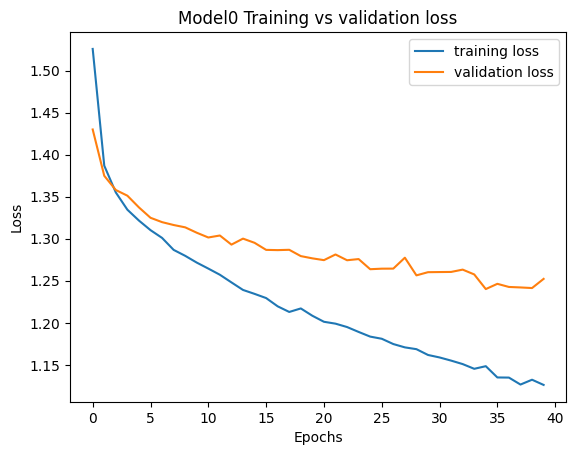

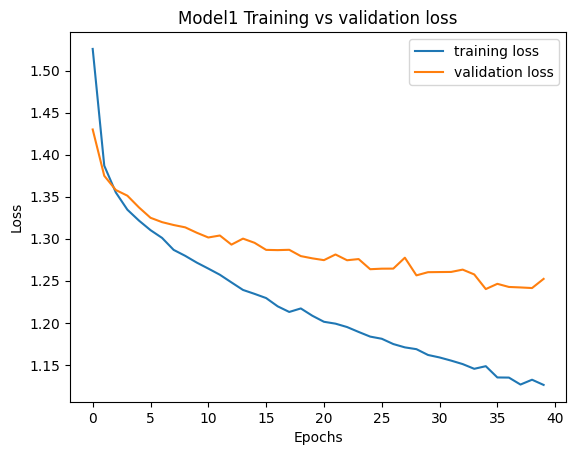

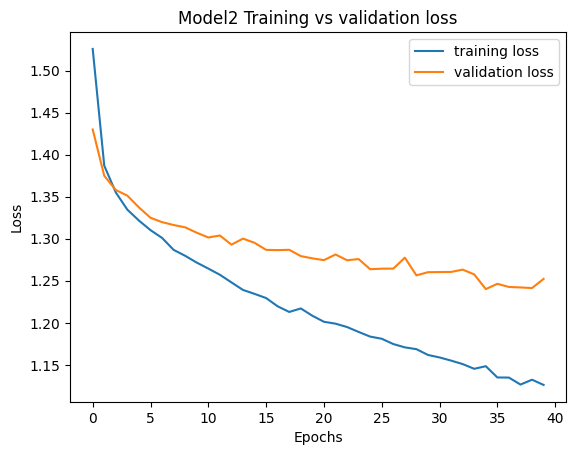

In [22]:
for i  in range (len(mods)):
    filepath=f"{path}/Training_validation_loss{i}.npy"
    if not new_models:
        try: 
            with open(filepath, "rb") as f:
                data = np.load(f)
        except:
            print(f"File with the data could not be found looking at address: {filepath}")
    else:
        with open(filepath, "wb") as f:
            np.save(f, mods[0][1])
            data = mods[0][1]
    plt.plot(data[0])
    plt.plot(data[1])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["training loss","validation loss"])
    plt.title(f"Model{i} Training vs validation loss")
    plt.show()
    